In [1]:
DATAPATH = '../data/'
XFERPATH = '~/gdrive_files/twitgen/'  # To transfer files from Google Colab
TRAIN_FNAME = 'embed_train_201906020021.csv'
VALID_FNAME = 'embed_valid_201906020021.csv'
TEST_FNAME = 'embed_test_201906020021.csv'
MODEL_TYPE_ID = 'lrp'

In [2]:
train_from = XFERPATH + TRAIN_FNAME
valid_from = XFERPATH + VALID_FNAME
test_from = XFERPATH + TEST_FNAME
!cp $train_from $DATAPATH
!cp $valid_from $DATAPATH
!cp $test_from $DATAPATH

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
timestamp = datetime.now().strftime('%Y%m%d%H%M')
timestamp

'201906021549'

In [5]:
df_train = pd.read_csv(DATAPATH+TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid = pd.read_csv(DATAPATH+VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test = pd.read_csv(DATAPATH+TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train.head().iloc[:,:7]

,,male,embed0,embed1,embed2,embed3,embed4,embed5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,-14081,80216,26727,19969,-5932,14983
815783987784187904,2019-05-24 15:36:01+00:00,False,-8092,-61741,24805,-21488,-20012,6800
3458239641,2019-05-24 19:00:37+00:00,False,-47872,-23766,28058,63213,9773,31955
1003729876250226688,2019-05-26 12:53:00+00:00,True,-16403,68003,17321,110208,4481,-44518
2360143940,2019-05-28 03:50:46+00:00,False,-11004,-11367,-47373,58910,31987,-48830


In [6]:
print(df_train.shape, df_valid.shape, df_test.shape)
print(df_train.index.get_level_values(1).min(), df_train.index.get_level_values(1).max())
print(df_valid.index.get_level_values(1).min(), df_valid.index.get_level_values(1).max())
print(df_test.index.get_level_values(1).min(), df_test.index.get_level_values(1).max())

(34146, 513) (10914, 513) (10450, 513)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [7]:
def getxy(df):
    X = df.drop(['male'],axis=1).values / 1e6
    y = 1*df.male.values
    return(X, y)
    
X_train, y_train = getxy(df_train)
X_valid, y_valid = getxy(df_valid)
X_test, y_test = getxy(df_test)

In [8]:
pca = PCA(64)
pca.fit(X_train)
print(pca.explained_variance_ratio_)

[0.07026239 0.04059233 0.03006268 0.02582044 0.02315705 0.02282998
 0.02029118 0.0195069  0.01811938 0.01759093 0.01698418 0.01581311
 0.01501578 0.01434089 0.0140568  0.01360939 0.01326368 0.01279015
 0.01203945 0.01196813 0.01169685 0.0114573  0.01104045 0.01083146
 0.0102916  0.01027193 0.00977283 0.00968517 0.00925644 0.00902606
 0.00875417 0.00859422 0.00852741 0.0083306  0.00827022 0.00796207
 0.00783106 0.00765176 0.0074753  0.00744967 0.00718645 0.00708487
 0.00698373 0.00684972 0.00677702 0.00660831 0.00643786 0.00635437
 0.00622376 0.00618738 0.00612636 0.00595008 0.00590991 0.00584006
 0.00578171 0.00572384 0.0056349  0.00553179 0.00534256 0.00528503
 0.00523847 0.00514848 0.00505982 0.00500143]


In [9]:
model = Pipeline([('pca',  PCA(50)),
                  ('poly', PolynomialFeatures()),
                  ('lr',   LogisticRegression(C=.08))])
model = model.fit(X_train, y_train)

/Users/andy/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
def save_predictions(df, predictions, which_set):
    pred_df = df[['male']].copy()
    pred_df['pred'] = predictions
    path = DATAPATH + MODEL_TYPE_ID + '_' + which_set + '_pred_' + timestamp + '.csv'
    pred_df.to_csv(path)    

In [11]:
y_train_pred = model.predict_proba(X_train)[:,1]
save_predictions(df_train, y_train_pred, 'train')
f1_score(y_train, y_train_pred>.5)

0.698561255631449

In [12]:
y_pred = model.predict_proba(X_valid)[:,1]
save_predictions(df_valid, y_pred, 'valid')
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[3312 2145]
 [1885 3572]]


0.63934132808305

In [13]:
accuracy_score(y_valid, y_pred>.5)

0.6307494960601063

In [14]:
y_test_pred = model.predict_proba(X_test)[:,1]
save_predictions(df_test, y_test_pred, 'test')
print( confusion_matrix(y_test, (y_test_pred>.5)) )
f1_score(y_test, y_test_pred>.5)

[[3110 2115]
 [1857 3368]]


0.6290623832648489

In [15]:
accuracy_score(y_test, y_test_pred>.5)

0.6199043062200957

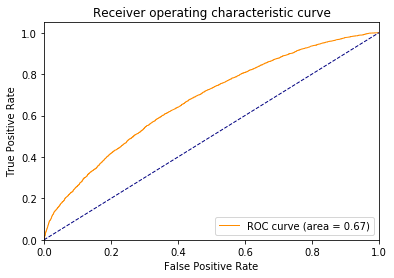

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

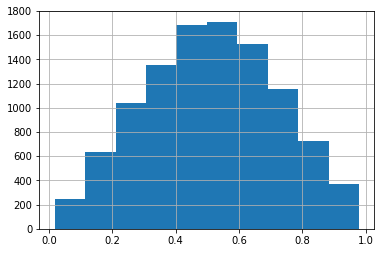

In [17]:
pd.Series(y_test_pred).hist()
plt.show()

In [18]:
df_acc = pd.DataFrame(columns=['minprob','maxprob','count','accuracy'])
for pbot in np.linspace(0,.9,10):
    ptop = pbot+.1
    mask = (y_test_pred>=pbot)&(y_test_pred<ptop)
    count = int(mask.sum())
    acc = accuracy_score(y_test[mask], y_test_pred[mask]>.5)
    row = pd.DataFrame({'minprob':[pbot], 'maxprob':[ptop], 'count':[count], 'accuracy':[acc]})
    df_acc = pd.concat([df_acc, row])
df_acc.set_index(['minprob','maxprob'])

,,count,accuracy
minprob,maxprob,,
0.0,0.1,190,0.884211
0.1,0.2,586,0.757679
0.2,0.3,1071,0.679739
0.3,0.4,1391,0.600288
0.4,0.5,1729,0.540775
0.5,0.6,1796,0.521715
0.6,0.7,1566,0.584291
0.7,0.8,1145,0.644541
0.8,0.9,709,0.771509


In [19]:
from joblib import dump
model_path = DATAPATH + MODEL_TYPE_ID + '_model_' + timestamp + '.joblib'
dump(model, model_path)

['../data/lrp_model_201906021549.joblib']